<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 18px 25px; margin-bottom: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: baseline;">
        <h1 style="font-family: 'Helvetica Neue', sans-serif; font-size: 24px; margin: 0; font-weight: 300;">
            Lab 11: Deep Reinforcement Learning - From DQN to Actor-Critic
        </h1>
        <span style="font-size: 11px; opacity: 0.9;">© Prof. Dehghani</span>
    </div>
    <p style="font-size: 13px; margin-top: 6px; margin-bottom: 0; opacity: 0.9;">
        IE 7295 Reinforcement Learning | Sutton & Barto Chapters 9, 13 | Advanced Level | 120 minutes
    </p>
</div>

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Background</h3>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        This lab introduces <strong>deep reinforcement learning</strong>, where neural networks approximate value functions and policies.
        We begin with <a href="https://www.nature.com/articles/nature14236" style="color: #17a2b8;">Deep Q-Networks (DQN)</a> by
        <a href="https://deepmind.google/discover/blog/deep-reinforcement-learning/" style="color: #17a2b8;">Mnih et al. (2015)</a>,
        which extended Q-learning to high-dimensional state spaces. We then explore policy gradient methods from
        <a href="http://incompleteideas.net/book/the-book-2nd.html" style="color: #17a2b8;">Sutton & Barto (2018)</a> Chapter 13,
        culminating in Actor-Critic architectures that power modern algorithms like
        <a href="https://arxiv.org/abs/1707.06347" style="color: #17a2b8;">PPO</a> and
        <a href="https://arxiv.org/abs/1801.01290" style="color: #17a2b8;">SAC</a>.
    </p>
</div>

<table style="width: 100%; border-spacing: 12px;">
<tr>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #17a2b8; vertical-align: top; width: 50%;">
    <h4 style="color: #17a2b8; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Learning Objectives</h4>
    <ul style="color: #555; line-height: 1.4; margin: 0; padding-left: 18px; font-size: 12px;">
        <li>Understand function approximation with neural networks</li>
        <li>Implement Deep Q-Networks with experience replay</li>
        <li>Recognize and fix the overestimation bias with Double DQN</li>
        <li>Master policy gradient methods and REINFORCE algorithm</li>
        <li>Build Actor-Critic architectures for stable learning</li>
        <li>Compare value-based vs policy-based approaches</li>
    </ul>
</td>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #00acc1; vertical-align: top; width: 50%;">
    <h4 style="color: #00acc1; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Algorithms Covered</h4>
    <div style="color: #555; font-size: 12px; line-height: 1.6;">
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">DQN</code> → Q-learning + Neural Networks</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">DDQN</code> → Fixes Q-value overestimation</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">REINFORCE</code> → Monte Carlo policy gradient</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">Actor-Critic</code> → Policy + Value function</div>
    </div>
</td>
</tr>
</table>

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 1: Environment Setup and CartPole Introduction</h2>
</div>

### The CartPole Environment

CartPole-v1 is a classic control problem where the goal is to balance a pole on a moving cart. The environment provides:

**State Space (4 continuous values):**
- Cart Position: $x \in [-2.4, 2.4]$
- Cart Velocity: $\dot{x} \in [-\infty, \infty]$
- Pole Angle: $\theta \in [-0.418, 0.418]$ rad (about ±24°)
- Pole Angular Velocity: $\dot{\theta} \in [-\infty, \infty]$

**Action Space (2 discrete actions):**
- 0: Push cart to the left
- 1: Push cart to the right

**Rewards:**
- +1 for every timestep the pole remains upright
- Episode ends when pole angle > ±12° or cart position > ±2.4
- Maximum episode length: 500 steps
- **Solved:** Average reward ≥ 475 over 100 consecutive episodes

<!-- IMAGE PLACEHOLDER: CartPole diagram showing state variables -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: CartPole state space visualization]</p>
</div>

In [2]:
"""
Cell 1: Install Dependencies and Load Utilities

Purpose:
  - Install required packages (PyTorch, Gym, etc.)
  - Load pretty_print utility for formatted output
  - Set random seeds for reproducibility

Key Libraries:
  - torch: Neural network implementation and training
  - gymnasium: OpenAI Gymnasium environments (successor to Gym)
  - numpy: Numerical operations
  - matplotlib: Visualization
"""

# Install required packages
!pip install torch gymnasium numpy matplotlib tqdm -q

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Fetch pretty_print utility
try:
    import requests
    url = 'https://raw.githubusercontent.com/mdehghani86/RL_labs/master/utility/rl_utility.py'
    response = requests.get(url)
    exec(response.text)
    pretty_print("Environment Ready",
                 "Successfully loaded dependencies and utilities<br>" +
                 "PyTorch, Gymnasium, and visualization tools are ready<br>" +
                 f"PyTorch version: {torch.__version__}",
                 style='success')
except Exception as e:
    # Fallback pretty_print
    def pretty_print(title, content, style='info'):
        themes = {
            'info': {'primary': '#17a2b8', 'secondary': '#0e5a63', 'background': '#f8f9fa'},
            'success': {'primary': '#28a745', 'secondary': '#155724', 'background': '#f8fff9'},
            'warning': {'primary': '#ffc107', 'secondary': '#e0a800', 'background': '#fffdf5'},
            'result': {'primary': '#6f42c1', 'secondary': '#4e2c8e', 'background': '#faf5ff'}
        }
        theme = themes.get(style, themes['info'])
        html = f'''
        <div style="border-radius: 5px; margin: 10px 0; width: 20cm; max-width: 20cm; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="background: linear-gradient(90deg, {theme['primary']} 0%, {theme['secondary']} 100%); padding: 10px 15px; border-radius: 5px 5px 0 0;">
                <strong style="color: white; font-size: 14px;">{title}</strong>
            </div>
            <div style="background: {theme['background']}; padding: 10px 15px; border-radius: 0 0 5px 5px; border-left: 3px solid {theme['primary']};">
                <div style="color: rgba(0,0,0,0.8); font-size: 12px; line-height: 1.5;">{content}</div>
            </div>
        </div>
        '''
        display(HTML(html))

    pretty_print("Fallback Mode",
                 f"Using local pretty_print<br>Dependencies loaded successfully",
                 style='warning')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cpu


In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Fetch pretty_print utility
try:
    import requests
    url = 'https://raw.githubusercontent.com/mdehghani86/RL_labs/master/utility/rl_utility.py'
    response = requests.get(url)
    exec(response.text)
    pretty_print("Environment Ready",
                 "Successfully loaded dependencies and utilities<br>" +
                 "PyTorch, Gymnasium, and visualization tools are ready<br>" +
                 f"PyTorch version: {torch.__version__}",
                 style='success')
except Exception as e:
    # Fallback pretty_print
    def pretty_print(title, content, style='info'):
        themes = {
            'info': {'primary': '#17a2b8', 'secondary': '#0e5a63', 'background': '#f8f9fa'},
            'success': {'primary': '#28a745', 'secondary': '#155724', 'background': '#f8fff9'},
            'warning': {'primary': '#ffc107', 'secondary': '#e0a800', 'background': '#fffdf5'},
            'result': {'primary': '#6f42c1', 'secondary': '#4e2c8e', 'background': '#faf5ff'}
        }
        theme = themes.get(style, themes['info'])
        html = f'''
        <div style="border-radius: 5px; margin: 10px 0; width: 20cm; max-width: 20cm; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="background: linear-gradient(90deg, {theme['primary']} 0%, {theme['secondary']} 100%); padding: 10px 15px; border-radius: 5px 5px 0 0;">
                <strong style="color: white; font-size: 14px;">{title}</strong>
            </div>
            <div style="background: {theme['background']}; padding: 10px 15px; border-radius: 0 0 5px 5px; border-left: 3px solid {theme['primary']};">
                <div style="color: rgba(0,0,0,0.8); font-size: 12px; line-height: 1.5;">{content}</div>
            </div>
        </div>
        '''
        display(HTML(html))

    pretty_print("Fallback Mode",
                 f"Using local pretty_print<br>Dependencies loaded successfully",
                 style='warning')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Create environment
env = gym.make('CartPole-v1')

# Get environment specifications
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

pretty_print("CartPole-v1 Environment",
             f"State space dimension: {state_dim}<br>" +
             f"Action space dimension: {action_dim}<br>" +
             f"State: [position, velocity, angle, angular_velocity]<br>" +
             f"Actions: 0=Left, 1=Right",
             style='info')

# Demonstrate random agent
def run_random_agent(env, num_episodes=3, render=True):
    """
    Run episodes with random action selection.

    Args:
        env: Gym environment
        num_episodes: Number of episodes to run
        render: Whether to render (set False in Colab)

    Returns:
        List of episode rewards
    """
    episode_rewards = []

    for episode in range(num_episodes):
        state, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            if render:
                try:
                    env.render()
                except:
                    pass  # Skip rendering if not available

            action = env.action_space.sample()  # Random action
            state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    return episode_rewards

# Run random agent
print("\nRandom Agent Performance:")
random_rewards = run_random_agent(env, num_episodes=3, render=False)

pretty_print("Random Agent Baseline",
             f"Average reward: {np.mean(random_rewards):.1f}<br>" +
             f"The pole falls quickly with random actions<br>" +
             f"Our goal: Train agents to achieve ~475+ reward",
             style='result')


Using device: cpu



Random Agent Performance:
Episode 1: Reward = 18.0
Episode 2: Reward = 13.0
Episode 3: Reward = 13.0


---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 2: Deep Q-Network (DQN)</h2>
</div>

### From Tabular Q-Learning to Function Approximation

In Lab 6, we used **tabular Q-learning** where Q-values were stored in a lookup table. This works well for discrete, small state spaces (Taxi: 500 states). However, CartPole has **continuous states** and even simple discretization leads to millions of states.

**Solution:** Use a **neural network** to approximate $Q(s,a)$.

### The Q-Learning Update Rule

Recall the Q-learning update from Chapter 6:

$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\right]$$

With function approximation using parameters $\theta$:

$$Q(s,a;\theta) \approx Q^*(s,a)$$

The loss function for a single transition becomes:

$$L(\theta) = \left[r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta)\right]^2$$

### DQN Innovations

**1. Experience Replay Buffer**

Neural networks require i.i.d. (independent and identically distributed) data, but RL generates correlated sequential data. Experience replay breaks these correlations:

$$\mathcal{D} = \{(s_t, a_t, r_t, s_{t+1})\}_{t=1}^N$$

Sample random minibatches from $\mathcal{D}$ for training.

**2. Target Network**

The Q-learning target $r + \gamma \max_{a'} Q(s',a';\theta)$ uses the same network being updated, causing instability. DQN uses a separate **target network** $\theta^-$ that is updated periodically:

$$L(\theta) = \left[r + \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta)\right]^2$$

Every $C$ steps: $\theta^- \leftarrow \theta$

<!-- IMAGE PLACEHOLDER: DQN architecture diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: DQN architecture with experience replay and target network]</p>
</div>

### DQN Algorithm Pseudocode

```
Initialize Q-network Q(s,a;θ) with random weights
Initialize target network Q(s,a;θ⁻) = Q(s,a;θ)
Initialize replay buffer D

For episode = 1 to M:
    Initialize state s
    For t = 1 to T:
        Select action: a = ε-greedy(Q(s,·;θ))
        Execute action a, observe r, s'
        Store transition (s,a,r,s') in D
        
        Sample random minibatch from D
        For each transition (sⱼ,aⱼ,rⱼ,s'ⱼ):
            yⱼ = rⱼ + γ max_a' Q(s'ⱼ,a';θ⁻)
        
        Update θ by minimizing (yⱼ - Q(sⱼ,aⱼ;θ))²
        
        Every C steps: θ⁻ ← θ
        s ← s'
```

In [7]:
"""
Cell 3: DQN Neural Network Architecture

Purpose:
  - Define the Q-network structure
  - Implement forward pass for Q-value prediction

Network Architecture:
  Input Layer: state_dim neurons (4 for CartPole)
  Hidden Layer 1: 128 neurons with ReLU activation
  Hidden Layer 2: 128 neurons with ReLU activation
  Output Layer: action_dim neurons (2 for CartPole)

  Output: Q(s,a) for each action a
"""

class DQN(nn.Module):
    """
    Deep Q-Network for value function approximation.

    Architecture:
        state → FC(128) → ReLU → FC(128) → ReLU → FC(action_dim)
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        """
        Initialize DQN.

        Args:
            state_dim (int): Dimension of state space
            action_dim (int): Number of actions
            hidden_dim (int): Hidden layer size
        """
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        """
        Forward pass through network.

        Args:
            state: State tensor [batch_size, state_dim]

        Returns:
            Q-values for each action [batch_size, action_dim]
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

# Test network
test_network = DQN(state_dim=4, action_dim=2)
test_state = torch.randn(1, 4)  # Batch of 1 state
test_output = test_network(test_state)

pretty_print("DQN Network Initialized",
             f"Network architecture: {state_dim} → 128 → 128 → {action_dim}<br>" +
             f"Total parameters: {sum(p.numel() for p in test_network.parameters()):,}<br>" +
             f"Test output shape: {test_output.shape}<br>" +
             f"Sample Q-values: {test_output.detach().numpy()}",
             style='success')

In [8]:
"""
Cell 4: Experience Replay Buffer

Purpose:
  - Implement replay buffer for storing transitions
  - Enable random sampling for breaking correlations

Key Methods:
  - push(): Add new transition to buffer
  - sample(): Sample random minibatch
  - __len__(): Return current buffer size
"""

class ReplayBuffer:
    """
    Experience Replay Buffer for DQN.

    Stores transitions (s, a, r, s', done) and samples random minibatches.
    """

    def __init__(self, capacity=10000):
        """
        Initialize replay buffer.

        Args:
            capacity (int): Maximum buffer size
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Add transition to buffer.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample random minibatch from buffer.

        Args:
            batch_size (int): Size of minibatch

        Returns:
            Tuple of (states, actions, rewards, next_states, dones)
        """
        # Random sample
        batch = random.sample(self.buffer, batch_size)

        # Unzip batch
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to numpy arrays
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return current buffer size."""
        return len(self.buffer)

# Test replay buffer
test_buffer = ReplayBuffer(capacity=1000)
for i in range(5):
    test_buffer.push(np.zeros(4), 0, 1.0, np.zeros(4), False)

pretty_print("Replay Buffer Initialized",
             f"Buffer capacity: 10,000 transitions<br>" +
             f"Current size: {len(test_buffer)}<br>" +
             f"Sample batch shape will be: (batch_size, state_dim)",
             style='info')

In [9]:
"""
Cell 5: DQN Agent Implementation

Purpose:
  - Implement complete DQN agent
  - Epsilon-greedy action selection
  - Training step with target network

Key Components:
  - Main Q-network (updated every step)
  - Target Q-network (updated every C steps)
  - Experience replay buffer
  - Epsilon-greedy exploration
"""

class DQNAgent:
    """
    DQN Agent with experience replay and target network.
    """

    def __init__(self, state_dim, action_dim, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.01, buffer_size=10000, batch_size=64,
                 target_update=10):
        """
        Initialize DQN agent.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            learning_rate: Learning rate for optimizer
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_decay: Epsilon decay rate
            epsilon_min: Minimum epsilon
            buffer_size: Replay buffer capacity
            batch_size: Minibatch size
            target_update: Steps between target network updates
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update
        self.step_count = 0

        # Initialize networks
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer and replay buffer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_size)

    def select_action(self, state, train=True):
        """
        Select action using epsilon-greedy policy.

        Args:
            state: Current state
            train: If True, use epsilon-greedy; else greedy

        Returns:
            Selected action
        """
        if train and random.random() < self.epsilon:
            # Explore: random action
            return random.randint(0, self.action_dim - 1)
        else:
            # Exploit: best action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def train_step(self):
        """
        Perform one training step.

        Returns:
            Loss value
        """
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Sample minibatch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Current Q-values: Q(s,a)
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values: r + γ max_a' Q_target(s',a')
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

pretty_print("DQN Agent Initialized",
             f"Main Q-network parameters: {sum(p.numel() for p in DQN(state_dim, action_dim).parameters()):,}<br>" +
             f"Target network: Separate copy, updated every {10} steps<br>" +
             f"Replay buffer capacity: 10,000 transitions<br>" +
             f"Ready to train!",
             style='success')

In [11]:

"""
Cell 6: Train DQN Agent

Purpose:
  - Train DQN agent on CartPole
  - Track episode rewards and losses
  - Visualize learning progress

Training Loop:
  1. Select action using epsilon-greedy
  2. Execute action and store transition
  3. Sample minibatch and update Q-network
  4. Periodically update target network

Expected Results:
  - Convergence to ~475+ reward in 200-400 episodes
"""

def train_dqn(num_episodes=400, max_steps=500):
    """
    Train DQN agent.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        episode_rewards: List of episode rewards
        losses: List of training losses
    """
    # Initialize agent and environment
    agent = DQNAgent(state_dim, action_dim)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training DQN",
                 f"Episodes: {num_episodes}<br>" +
                 f"Max steps per episode: {max_steps}<br>" +
                 f"This may take 5-10 minutes...",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training DQN"):
        state, info = env.reset() # gymnasium returns state and info from reset()
        episode_reward = 0
        episode_losses = []

        for step in range(max_steps):
            # Select and execute action
            action = agent.select_action(state, train=True)
            next_state, reward, terminated, truncated, info = env.step(action) # Corrected unpacking
            done = terminated or truncated # Combine for 'done' status

            # Store transition
            agent.replay_buffer.push(state, action, reward, next_state, done)

            # Train
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))

        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

    env.close()
    return agent, episode_rewards, losses

# Train DQN
dqn_agent, dqn_rewards, dqn_losses = train_dqn(num_episodes=400)

pretty_print("DQN Training Complete",
             f"Final 100-episode average: {np.mean(dqn_rewards[-100:]):.2f}<br>" +
             f"Best episode reward: {max(dqn_rewards):.0f}<br>" +
             f"Final epsilon: {dqn_agent.epsilon:.3f}",
             style='result')

Training DQN:  12%|█▎        | 50/400 [00:20<02:44,  2.13it/s]

Episode 50: Avg Reward = 147.40, Epsilon = 0.010


Training DQN:  25%|██▌       | 100/400 [00:47<02:58,  1.68it/s]

Episode 100: Avg Reward = 186.00, Epsilon = 0.010


Training DQN:  39%|███▉      | 157/400 [01:34<01:08,  3.54it/s]

Episode 150: Avg Reward = 331.52, Epsilon = 0.010


Training DQN:  50%|█████     | 200/400 [02:03<04:53,  1.47s/it]

Episode 200: Avg Reward = 203.36, Epsilon = 0.010


Training DQN:  63%|██████▎   | 252/400 [02:58<00:48,  3.07it/s]

Episode 250: Avg Reward = 374.82, Epsilon = 0.010


Training DQN:  75%|███████▌  | 300/400 [03:33<02:04,  1.24s/it]

Episode 300: Avg Reward = 243.80, Epsilon = 0.010


Training DQN:  88%|████████▊ | 350/400 [04:00<00:33,  1.51it/s]

Episode 350: Avg Reward = 175.28, Epsilon = 0.010


Training DQN: 100%|██████████| 400/400 [04:52<00:00,  1.37it/s]

Episode 400: Avg Reward = 347.54, Epsilon = 0.010


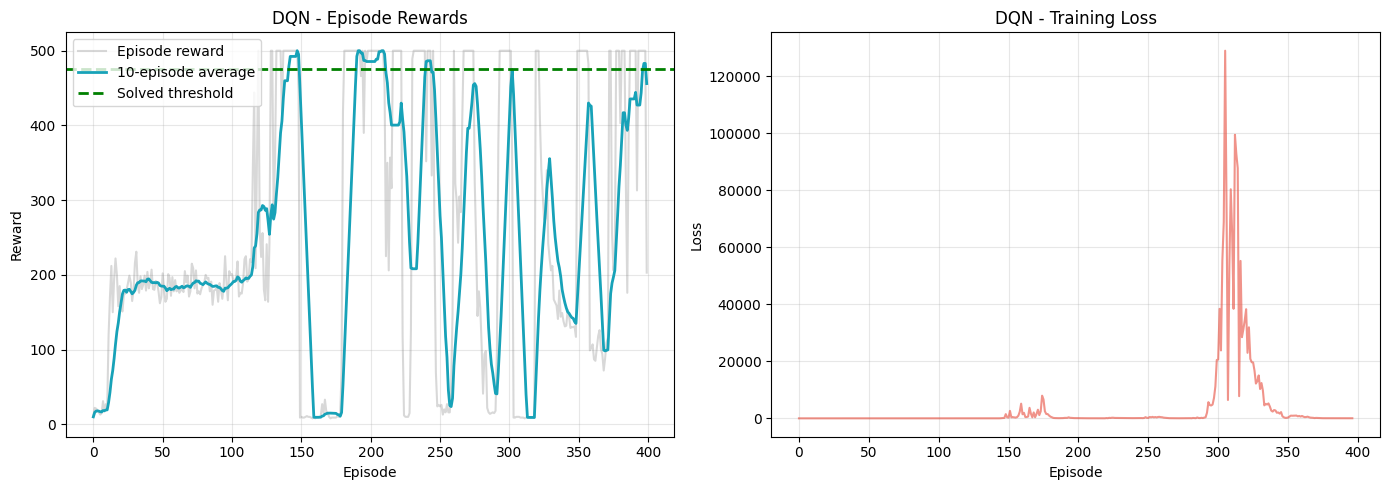

In [18]:
"""
Cell 7: Visualize DQN Training Results

Purpose:
  - Plot learning curves
  - Analyze training dynamics
"""

def plot_training_results(rewards, losses, title, window=10):
    """
    Plot training results.

    Args:
        rewards: List of episode rewards
        losses: List of losses
        title: Plot title
        window: Moving average window
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot rewards
    ax1.plot(rewards, alpha=0.3, color='gray', label='Episode reward')
    moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    ax1.plot(moving_avg, color='#17a2b8', linewidth=2, label=f'{window}-episode average')
    ax1.axhline(y=475, color='green', linestyle='--', linewidth=2, label='Solved threshold')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'{title} - Episode Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot losses
    if losses:
        ax2.plot(losses, color='#e74c3c', alpha=0.6)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - Training Loss')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot DQN results
plot_training_results(dqn_rewards, dqn_losses, 'DQN', window=10)

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 3: Double DQN (DDQN)</h2>
</div>

### The Overestimation Problem

Standard DQN suffers from **Q-value overestimation** due to the max operator in the target:

$$y = r + \gamma \max_{a'} Q(s',a';\theta^-)$$

The same network is used to both **select** and **evaluate** the best action. This leads to systematic positive bias:

$$\mathbb{E}[\max_{a'} Q(s',a')] \geq \max_{a'} \mathbb{E}[Q(s',a')]$$

### Double Q-Learning Solution

**Key Idea:** Decouple action selection from action evaluation using two networks.

**DQN Target:**
$$y^{\text{DQN}} = r + \gamma Q(s', \arg\max_{a'} Q(s',a';\theta^-); \theta^-)$$
$$\text{↑ Same network selects AND evaluates}$$

**DDQN Target:**
$$y^{\text{DDQN}} = r + \gamma Q(s', \arg\max_{a'} Q(s',a';\theta); \theta^-)$$
$$\text{↑ Main network selects, target network evaluates}$$

<!-- IMAGE PLACEHOLDER: DQN vs DDQN comparison diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: DQN overestimation vs DDQN correction]</p>
</div>

### Implementation Change

DDQN requires only a **single line change** from DQN:

<div style="background: #fff3e0; padding: 15px 20px; margin: 20px 0; border-left: 3px solid #ff9800;">
    <h3 style="color: #ff9800; font-size: 14px; margin: 0 0 8px 0;">Hands-On Exercise 1: Implement Double DQN</h3>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Modify the DQN training step to implement DDQN. Only the target computation needs to change.
        <br><br>
        <strong>Hint:</strong> Use the main Q-network to select the best action, then use the target network to evaluate it.
    </p>
</div>

In [15]:
class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent - inherits from DQN, modifies target computation.
    """

    def train_step(self):
        """
        Perform one DDQN training step.

        Key difference from DQN: Decoupled action selection and evaluation.

        Returns:
            Loss value
        """
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Sample minibatch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Current Q-values: Q(s,a)
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # ================================================================
        # DOUBLE DQN TARGET COMPUTATION
        # ================================================================
        with torch.no_grad():
            # HANDS-ON EXERCISE 1: Complete the DDQN target computation

            # Step 1: Use MAIN network to SELECT best actions for next states
            next_actions = self.q_network(next_states).argmax(1)

            # Step 2: Use TARGET network to EVALUATE those actions
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()

            # Step 3: Compute target Q-values
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss (same as DQN)
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

In [17]:

"""
Cell 9: Train Double DQN Agent

Purpose:
  - Train DDQN agent
  - Compare with DQN performance
"""

def train_ddqn(num_episodes=400, max_steps=500):
    """
    Train Double DQN agent.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        losses: List of training losses
    """
    # Initialize agent and environment
    agent = DoubleDQNAgent(state_dim, action_dim)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training Double DQN",
                 f"Episodes: {num_episodes}<br>" +
                 f"Expected improvement: More stable, less overestimation",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training DDQN"):
        state, info = env.reset() # gymnasium returns state and info from reset()
        episode_reward = 0
        episode_losses = []

        for step in range(max_steps):
            action = agent.select_action(state, train=True)
            next_state, reward, terminated, truncated, info = env.step(action) # Corrected unpacking
            done = terminated or truncated # Combine for 'done' status

            agent.replay_buffer.push(state, action, reward, next_state, done)

            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")

    env.close()
    return agent, episode_rewards, losses

# Train DDQN
ddqn_agent, ddqn_rewards, ddqn_losses = train_ddqn(num_episodes=400)

pretty_print("Double DQN Training Complete",
             f"Final 100-episode average: {np.mean(ddqn_rewards[-100:]):.2f}<br>" +
             f"Best episode reward: {max(ddqn_rewards):.0f}<br>" +
             f"Comparison with DQN: Check plots below",
             style='result')

Training DDQN:  12%|█▎        | 50/400 [00:25<05:33,  1.05it/s]

Episode 50: Avg Reward = 179.12


Training DDQN:  25%|██▌       | 100/400 [01:19<06:18,  1.26s/it]

Episode 100: Avg Reward = 372.24


Training DDQN:  38%|███▊      | 150/400 [02:27<06:07,  1.47s/it]

Episode 150: Avg Reward = 469.32


Training DDQN:  50%|█████     | 200/400 [03:28<02:39,  1.25it/s]

Episode 200: Avg Reward = 404.00


Training DDQN:  62%|██████▏   | 248/400 [04:07<00:11, 13.50it/s]

Episode 250: Avg Reward = 261.22


Training DDQN:  75%|███████▌  | 300/400 [05:12<01:51,  1.12s/it]

Episode 300: Avg Reward = 404.84


Training DDQN:  88%|████████▊ | 350/400 [05:58<00:38,  1.29it/s]

Episode 350: Avg Reward = 287.36


Training DDQN: 100%|██████████| 400/400 [06:44<00:00,  1.01s/it]

Episode 400: Avg Reward = 285.34


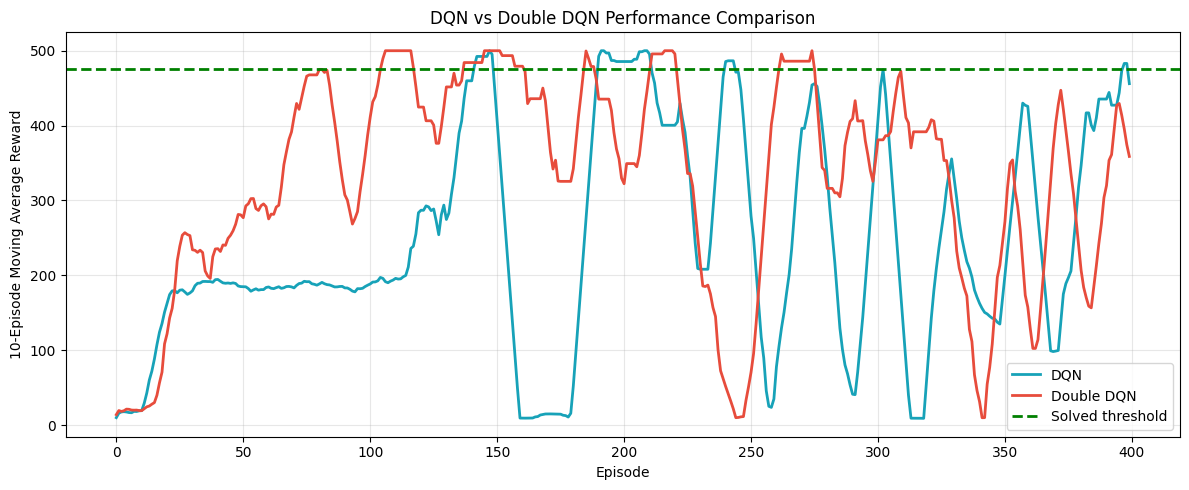

In [19]:
"""
Cell 10: Compare DQN vs DDQN

Purpose:
  - Visualize performance comparison
  - Analyze differences in learning dynamics
"""

# Plot comparison
plt.figure(figsize=(12, 5))

window = 10

# DQN
dqn_ma = [np.mean(dqn_rewards[max(0, i-window):i+1]) for i in range(len(dqn_rewards))]
plt.plot(dqn_ma, label='DQN', color='#17a2b8', linewidth=2)

# DDQN
ddqn_ma = [np.mean(ddqn_rewards[max(0, i-window):i+1]) for i in range(len(ddqn_rewards))]
plt.plot(ddqn_ma, label='Double DQN', color='#e74c3c', linewidth=2)

plt.axhline(y=475, color='green', linestyle='--', linewidth=2, label='Solved threshold')
plt.xlabel('Episode')
plt.ylabel(f'{window}-Episode Moving Average Reward')
plt.title('DQN vs Double DQN Performance Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
pretty_print("DQN vs DDQN Comparison",
             f"<strong>DQN:</strong><br>" +
             f"  • Final average: {np.mean(dqn_rewards[-100:]):.2f}<br>" +
             f"  • Best episode: {max(dqn_rewards):.0f}<br><br>" +
             f"<strong>Double DQN:</strong><br>" +
             f"  • Final average: {np.mean(ddqn_rewards[-100:]):.2f}<br>" +
             f"  • Best episode: {max(ddqn_rewards):.0f}<br><br>" +
             f"<strong>Observation:</strong> DDQN often shows more stable learning",
             style='result')

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 4: Policy Gradient Methods - REINFORCE</h2>
</div>

### A Different Approach: Direct Policy Optimization

So far, we've used **value-based methods** (DQN, DDQN) that:
1. Learn Q(s,a)
2. Derive policy: $\pi(s) = \arg\max_a Q(s,a)$

**Policy gradient methods** take a fundamentally different approach:
- **Directly parameterize the policy:** $\pi(a|s;\theta)$
- **Optimize policy parameters** to maximize expected return

### Why Policy Gradients?

**Advantages:**
1. Can handle **continuous action spaces** (DQN cannot)
2. Can learn **stochastic policies** (sometimes optimal)
3. Better **convergence properties** (smooth policy changes)

**Disadvantages:**
1. Higher **variance** in gradient estimates
2. Can converge to **local optima**
3. Typically requires more **samples**

### Policy Parameterization

For discrete actions, use softmax policy:

$$\pi(a|s;\theta) = \frac{e^{h(s,a;\theta)}}{\sum_{a'} e^{h(s,a';\theta)}}$$

where $h(s,a;\theta)$ are **action preferences** from a neural network.

### The Policy Gradient Theorem (Sutton & Barto, Section 13.2)

**Objective:** Maximize expected return

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$$

where $\tau$ is a trajectory and $R(\tau) = \sum_t r_t$ is the return.

**The gradient:**

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^T \nabla_\theta \log \pi(a_t|s_t;\theta) \cdot G_t\right]$$

where $G_t = \sum_{t'=t}^T \gamma^{t'-t} r_{t'}$ is the return from timestep $t$.

**Intuition:**
- $G_t > 0$: Increase probability of action $a_t$ in state $s_t$
- $G_t < 0$: Decrease probability of action $a_t$ in state $s_t$

### REINFORCE Algorithm (Monte Carlo Policy Gradient)

```
Initialize policy parameters θ

For each episode:
    Generate episode τ = (s₀, a₀, r₁, s₁, a₁, r₂, ..., s_T) using π(·|·;θ)
    
    For each timestep t in episode:
        Compute return: G_t = Σ γᵏ r_{t+k}
        Update: θ ← θ + α G_t ∇_θ log π(a_t|s_t;θ)
```

<!-- IMAGE PLACEHOLDER: Policy gradient intuition diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: Policy gradient making good actions more likely]</p>
</div>

In [ ]:
"""
Cell 11: Policy Network Implementation

Purpose:
  - Implement policy network that outputs action probabilities
  - Enable action sampling and log probability computation

Network Architecture:
  Input: state
  Hidden layers: 128 neurons with ReLU
  Output: action probabilities (softmax)
"""

class PolicyNetwork(nn.Module):
    """
    Policy Network for REINFORCE.
    Outputs probability distribution over actions.
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        """
        Initialize policy network.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            hidden_dim: Hidden layer size
        """
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        """
        Forward pass.

        Args:
            state: State tensor

        Returns:
            Action probabilities (after softmax)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.fc3(x), dim=-1)
        return action_probs

    def select_action(self, state):
        """
        Select action by sampling from policy.

        Args:
            state: Current state

        Returns:
            action: Sampled action
            log_prob: Log probability of action
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = self.forward(state_tensor)

        # Sample action from distribution
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob

# Test policy network
test_policy = PolicyNetwork(state_dim, action_dim)
test_state = np.random.randn(state_dim)
test_action, test_log_prob = test_policy.select_action(test_state)

pretty_print("Policy Network Initialized",
             f"Network outputs action probabilities<br>" +
             f"Sample action: {test_action}<br>" +
             f"Log probability: {test_log_prob.item():.3f}<br>" +
             f"Actions are sampled stochastically",
             style='success')

In [ ]:
"""
Cell 12: REINFORCE Agent Implementation

Purpose:
  - Implement complete REINFORCE algorithm
  - Monte Carlo return computation
  - Policy gradient update

Key Components:
  - Episode memory (states, actions, rewards)
  - Return computation with discount
  - Policy gradient ascent
"""

class REINFORCEAgent:
    """
    REINFORCE (Monte Carlo Policy Gradient) Agent.
    """

    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99):
        """
        Initialize REINFORCE agent.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            learning_rate: Learning rate
            gamma: Discount factor
        """
        self.gamma = gamma

        # Initialize policy network
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

        # Episode memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

    def select_action(self, state):
        """
        Select action using current policy.

        Args:
            state: Current state

        Returns:
            action: Selected action
        """
        action, log_prob = self.policy.select_action(state)

        # Store for episode
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)

        return action

    def store_reward(self, reward):
        """Store reward for current timestep."""
        self.rewards.append(reward)

    def update(self):
        """
        Perform REINFORCE update after episode completion.

        Steps:
          1. Compute returns G_t for each timestep
          2. Compute policy gradient
          3. Update policy parameters
        """
        # Compute returns
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        # Normalize returns (reduce variance)
        returns = torch.FloatTensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute policy loss
        policy_loss = []
        for log_prob, G in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * G)  # Negative for gradient ascent

        policy_loss = torch.stack(policy_loss).sum()

        # Update policy
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # Clear episode memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

        return policy_loss.item()

pretty_print("REINFORCE Agent Initialized",
             "Algorithm: Monte Carlo Policy Gradient<br>" +
             "Update: After each complete episode<br>" +
             "No replay buffer needed (on-policy)",
             style='success')

In [ ]:
"""
Cell 13: Train REINFORCE Agent

Purpose:
  - Train REINFORCE agent on CartPole
  - Compare with value-based methods (DQN/DDQN)

Expected Behavior:
  - Higher variance than DQN
  - May take longer to converge
  - But demonstrates direct policy optimization
"""

def train_reinforce(num_episodes=1000, max_steps=500):
    """
    Train REINFORCE agent.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        losses: List of losses
    """
    agent = REINFORCEAgent(state_dim, action_dim, learning_rate=0.001)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training REINFORCE",
                 f"Episodes: {num_episodes}<br>" +
                 f"Note: Policy gradient methods typically have higher variance",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training REINFORCE"):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

            if done:
                break

        # Update policy after episode
        loss = agent.update()

        episode_rewards.append(episode_reward)
        losses.append(loss)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")

    env.close()
    return agent, episode_rewards, losses

# Train REINFORCE
reinforce_agent, reinforce_rewards, reinforce_losses = train_reinforce(num_episodes=1000)

pretty_print("REINFORCE Training Complete",
             f"Final 100-episode average: {np.mean(reinforce_rewards[-100:]):.2f}<br>" +
             f"Best episode reward: {max(reinforce_rewards):.0f}<br>" +
             f"Notice the higher variance compared to DQN",
             style='result')

In [ ]:
"""
Cell 14: Visualize REINFORCE Results

Purpose:
  - Plot REINFORCE learning curves
  - Analyze variance in policy gradient methods
"""

plot_training_results(reinforce_rewards, reinforce_losses, 'REINFORCE', window=20)

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 5: Actor-Critic Methods</h2>
</div>

### Combining the Best of Both Worlds

REINFORCE has high variance because it uses full episode returns. We can reduce variance by introducing a **baseline**.

### Actor-Critic Architecture

**Two networks:**
1. **Actor:** Policy network $\pi(a|s;\theta)$ (decides which action to take)
2. **Critic:** Value network $V(s;w)$ (evaluates how good the state is)

**The advantage function:**

$$A(s,a) = Q(s,a) - V(s)$$

Measures how much better action $a$ is compared to the average action in state $s$.

Using TD(0), we approximate the advantage:

$$A(s,a) \approx r + \gamma V(s') - V(s) = \delta$$

This is the **TD error**.

### Actor-Critic Update Rules

**Critic update (TD learning):**
$$w \leftarrow w + \alpha_w \delta \nabla_w V(s;w)$$

**Actor update (policy gradient with advantage):**
$$\theta \leftarrow \theta + \alpha_\theta \delta \nabla_\theta \log \pi(a|s;\theta)$$

<!-- IMAGE PLACEHOLDER: Actor-Critic architecture diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: Actor-Critic architecture with two networks]</p>
</div>

### Advantages of Actor-Critic

1. **Lower variance** than REINFORCE (uses TD error instead of returns)
2. **Online learning** (updates every step, not just end of episode)
3. **Foundation for modern algorithms** (PPO, A3C, SAC, TD3)
4. **Combines value and policy** approaches

<div style="background: #fff3e0; padding: 15px 20px; margin: 20px 0; border-left: 3px solid #ff9800;">
    <h3 style="color: #ff9800; font-size: 14px; margin: 0 0 8px 0;">Hands-On Exercise 2: Implement Actor-Critic Agent</h3>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Complete the Actor-Critic implementation by filling in the update step.
        <br><br>
        <strong>Key steps:</strong><br>
        1. Compute TD error: δ = r + γV(s') - V(s)<br>
        2. Update critic using TD error<br>
        3. Update actor using TD error as advantage
    </p>
</div>

In [ ]:
"""
Cell 15: Value Network for Critic

Purpose:
  - Implement value network V(s;w)
  - Estimates state values for advantage computation
"""

class ValueNetwork(nn.Module):
    """
    Value Network for Actor-Critic (Critic).
    Estimates V(s).
    """

    def __init__(self, state_dim, hidden_dim=128):
        """
        Initialize value network.

        Args:
            state_dim: Dimension of state space
            hidden_dim: Hidden layer size
        """
        super(ValueNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output: single value V(s)

    def forward(self, state):
        """
        Forward pass.

        Args:
            state: State tensor

        Returns:
            State value V(s)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

pretty_print("Value Network (Critic)",
             "Network outputs state values V(s)<br>" +
             "Used to compute TD error for advantage estimation",
             style='info')

In [ ]:
"""
Cell 16: Actor-Critic Agent Implementation

Purpose:
  - Implement complete Actor-Critic algorithm
  - Combine policy network (actor) and value network (critic)
  - Update both networks using TD error
"""

class ActorCriticAgent:
    """
    Actor-Critic Agent.

    Components:
      - Actor: Policy network
      - Critic: Value network
    """

    def __init__(self, state_dim, action_dim,
                 actor_lr=0.001, critic_lr=0.005, gamma=0.99):
        """
        Initialize Actor-Critic agent.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            actor_lr: Actor learning rate
            critic_lr: Critic learning rate (typically higher)
            gamma: Discount factor
        """
        self.gamma = gamma

        # Actor (policy)
        self.actor = PolicyNetwork(state_dim, action_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critic (value function)
        self.critic = ValueNetwork(state_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def select_action(self, state):
        """
        Select action using actor.

        Args:
            state: Current state

        Returns:
            action: Selected action
            log_prob: Log probability of action
        """
        return self.actor.select_action(state)

    def update(self, state, action, reward, next_state, done, log_prob):
        """
        Perform Actor-Critic update.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended
            log_prob: Log probability of action

        Returns:
            actor_loss: Actor loss value
            critic_loss: Critic loss value
        """
        # Convert to tensors
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        reward_tensor = torch.FloatTensor([reward]).to(device)
        done_tensor = torch.FloatTensor([done]).to(device)

        # ================================================================
        # HANDS-ON EXERCISE 2: Complete the Actor-Critic update
        # ================================================================

        # Step 1: Compute state values
        # Hint: value = self.critic(state_tensor)
        value = ### YOUR CODE HERE ###

        # Step 2: Compute next state value (with no grad)
        with torch.no_grad():
            # Hint: next_value = self.critic(next_state_tensor)
            next_value = ### YOUR CODE HERE ###

        # Step 3: Compute TD error (advantage)
        # Hint: td_error = reward + gamma * next_value * (1 - done) - value
        td_error = ### YOUR CODE HERE ###

        # Step 4: Update Critic
        # Hint: critic_loss = td_error.pow(2)
        critic_loss = ### YOUR CODE HERE ###
        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()

        # Step 5: Update Actor
        # Hint: actor_loss = -log_prob * td_error.detach()
        actor_loss = ### YOUR CODE HERE ###
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss.item(), critic_loss.item()

pretty_print("Actor-Critic Agent Initialized",
             "Two networks: Actor (policy) + Critic (value)<br>" +
             "Update strategy: TD error as advantage<br>" +
             "Lower variance than REINFORCE",
             style='success')

In [ ]:
"""
Cell 17: Train Actor-Critic Agent

Purpose:
  - Train Actor-Critic agent
  - Compare with all previous algorithms

Expected Results:
  - Lower variance than REINFORCE
  - Faster convergence than REINFORCE
  - Competitive with DQN/DDQN
"""

def train_actor_critic(num_episodes=500, max_steps=500):
    """
    Train Actor-Critic agent.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        actor_losses: List of actor losses
        critic_losses: List of critic losses
    """
    agent = ActorCriticAgent(state_dim, action_dim)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    actor_losses = []
    critic_losses = []

    pretty_print("Training Actor-Critic",
                 f"Episodes: {num_episodes}<br>" +
                 f"Expected: Lower variance, faster convergence",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training Actor-Critic"):
        state = env.reset()
        episode_reward = 0
        episode_actor_losses = []
        episode_critic_losses = []

        for step in range(max_steps):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            # Update both networks
            actor_loss, critic_loss = agent.update(state, action, reward,
                                                   next_state, done, log_prob)

            episode_actor_losses.append(actor_loss)
            episode_critic_losses.append(critic_loss)
            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        actor_losses.append(np.mean(episode_actor_losses))
        critic_losses.append(np.mean(episode_critic_losses))

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")

    env.close()
    return agent, episode_rewards, actor_losses, critic_losses

# Train Actor-Critic
ac_agent, ac_rewards, ac_actor_losses, ac_critic_losses = train_actor_critic(num_episodes=500)

pretty_print("Actor-Critic Training Complete",
             f"Final 100-episode average: {np.mean(ac_rewards[-100:]):.2f}<br>" +
             f"Best episode reward: {max(ac_rewards):.0f}<br>" +
             f"Notice smoother learning than REINFORCE",
             style='result')

In [ ]:
"""
Cell 18: Visualize Actor-Critic Results

Purpose:
  - Plot Actor-Critic learning curves
  - Show both actor and critic losses
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Rewards
window = 10
ac_ma = [np.mean(ac_rewards[max(0, i-window):i+1]) for i in range(len(ac_rewards))]
ax1.plot(ac_rewards, alpha=0.3, color='gray', label='Episode reward')
ax1.plot(ac_ma, color='#17a2b8', linewidth=2, label=f'{window}-episode average')
ax1.axhline(y=475, color='green', linestyle='--', linewidth=2, label='Solved')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Actor-Critic - Episode Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Losses
ax2.plot(ac_actor_losses, alpha=0.7, label='Actor Loss', color='#e74c3c')
ax2.plot(ac_critic_losses, alpha=0.7, label='Critic Loss', color='#3498db')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Loss')
ax2.set_title('Actor-Critic - Training Losses')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 6: Comprehensive Comparison</h2>
</div>

Now let's compare all four algorithms we've implemented.

In [ ]:
"""
Cell 19: Compare All Algorithms

Purpose:
  - Plot learning curves for all algorithms
  - Analyze strengths and weaknesses
"""

plt.figure(figsize=(14, 6))

window = 20

# DQN
dqn_ma = [np.mean(dqn_rewards[max(0, i-window):i+1]) for i in range(len(dqn_rewards))]
plt.plot(dqn_ma, label='DQN', color='#3498db', linewidth=2)

# Double DQN
ddqn_ma = [np.mean(ddqn_rewards[max(0, i-window):i+1]) for i in range(len(ddqn_rewards))]
plt.plot(ddqn_ma, label='Double DQN', color='#e74c3c', linewidth=2)

# REINFORCE
reinforce_ma = [np.mean(reinforce_rewards[max(0, i-window):i+1]) for i in range(len(reinforce_rewards))]
plt.plot(reinforce_ma, label='REINFORCE', color='#9b59b6', linewidth=2, alpha=0.7)

# Actor-Critic
ac_ma = [np.mean(ac_rewards[max(0, i-window):i+1]) for i in range(len(ac_rewards))]
plt.plot(ac_ma, label='Actor-Critic', color='#2ecc71', linewidth=2)

plt.axhline(y=475, color='gray', linestyle='--', linewidth=2, label='Solved threshold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel(f'{window}-Episode Moving Average Reward', fontsize=12)
plt.title('Deep RL Algorithm Comparison on CartPole-v1', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
def get_stats(rewards, name):
    final_avg = np.mean(rewards[-100:])
    best = max(rewards)
    # Find when solved (average > 475 for 100 episodes)
    solved_at = None
    for i in range(100, len(rewards)):
        if np.mean(rewards[i-100:i]) >= 475:
            solved_at = i
            break
    return name, final_avg, best, solved_at

stats = [
    get_stats(dqn_rewards, 'DQN'),
    get_stats(ddqn_rewards, 'Double DQN'),
    get_stats(reinforce_rewards, 'REINFORCE'),
    get_stats(ac_rewards, 'Actor-Critic')
]

pretty_print("Algorithm Comparison Summary",
             "<table style='width: 100%; border-collapse: collapse;'>" +
             "<tr style='background: #f8f9fa;'>" +
             "<th style='padding: 8px; text-align: left;'>Algorithm</th>" +
             "<th style='padding: 8px; text-align: center;'>Final Avg</th>" +
             "<th style='padding: 8px; text-align: center;'>Best</th>" +
             "<th style='padding: 8px; text-align: center;'>Solved At</th>" +
             "</tr>" +
             "".join([
                 f"<tr>" +
                 f"<td style='padding: 8px;'>{name}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{final:.1f}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{best:.0f}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{solved if solved else 'N/A'}</td>" +
                 f"</tr>"
                 for name, final, best, solved in stats
             ]) +
             "</table>",
             style='result')

In [ ]:
"""
Cell 20: Test Trained Agents

Purpose:
  - Visualize trained agent performance
  - Compare with initial random agent
"""

def test_agent(agent, agent_type='dqn', num_episodes=5, render=False):
    """
    Test trained agent.

    Args:
        agent: Trained agent
        agent_type: Type of agent ('dqn', 'reinforce', 'actor_critic')
        num_episodes: Number of test episodes
        render: Whether to render

    Returns:
        List of episode rewards
    """
    env = gym.make('CartPole-v1')
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            if render:
                try:
                    env.render()
                except:
                    pass

            # Select action (no exploration)
            if agent_type in ['dqn', 'ddqn']:
                action = agent.select_action(state, train=False)
            elif agent_type == 'reinforce':
                action, _ = agent.policy.select_action(state)
            elif agent_type == 'actor_critic':
                action, _ = agent.select_action(state)

            state, reward, done, _ = env.step(action)
            episode_reward += reward

        rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    return rewards

# Test best agent (choose one)
print("Testing Actor-Critic agent:")
test_rewards = test_agent(ac_agent, agent_type='actor_critic', num_episodes=5)

pretty_print("Trained Agent Performance",
             f"Average test reward: {np.mean(test_rewards):.2f}<br>" +
             f"Compare with random agent (~20-40 reward)<br>" +
             f"Trained agent achieves near-optimal performance!",
             style='result')

<div style="background: #f8f9fa; padding: 15px 20px; margin-top: 30px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Key Findings</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>1. Function Approximation:</strong> Neural networks enable RL in high-dimensional continuous state spaces where tabular methods fail.</p>
        
        <p><strong>2. DQN Innovations:</strong> Experience replay and target networks are crucial for stable deep RL training. Without them, neural networks often diverge.</p>
        
        <p><strong>3. Overestimation Bias:</strong> Double DQN's simple modification (decoupling action selection and evaluation) significantly improves stability and performance.</p>
        
        <p><strong>4. Policy Gradients:</strong> REINFORCE demonstrates direct policy optimization but suffers from high variance. Suitable for continuous action spaces where value-based methods struggle.</p>
        
        <p><strong>5. Actor-Critic Synthesis:</strong> Combining policy gradients with value functions (Actor-Critic) achieves lower variance and more stable learning than pure policy gradient methods.</p>
        
        <p><strong>6. Algorithm Selection:</strong> Value-based (DQN/DDQN) excel in discrete actions with sample efficiency. Policy-based (REINFORCE/Actor-Critic) handle continuous actions and stochastic policies. Actor-Critic offers best overall balance.</p>
        
        <p><strong>7. Modern Extensions:</strong> These foundational algorithms form the basis for state-of-the-art methods: PPO, A3C, SAC, TD3, which add further stability and performance improvements.</p>
    </div>
</div>

<div style="background: #fff3e0; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #ff9800;">
    <h3 style="color: #ff9800; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Questions for Reflection</h3>
    <ol style="color: #555; line-height: 1.8; margin: 8px 0 0 0; padding-left: 20px; font-size: 13px;">
        <li>Why is experience replay essential for DQN but not needed for Actor-Critic? What makes off-policy vs on-policy learning different?</li>
        <li>How would you adapt DQN to handle continuous action spaces? What modifications would be required?</li>
        <li>What causes the high variance in REINFORCE? How does the Actor-Critic baseline reduce this variance?</li>
        <li>Why does Double DQN use the main network for action selection and target network for evaluation, rather than the reverse?</li>
        <li>How do these algorithms scale to more complex environments like Atari games or robotic control?</li>
        <li>What are the trade-offs between sample efficiency (DQN) and stable convergence (Actor-Critic)?</li>
        <li>How would you implement multi-step returns (n-step) or eligibility traces in these algorithms?</li>
        <li>What role does the learning rate ratio (actor vs critic) play in Actor-Critic stability?</li>
    </ol>
</div>

<div style="background: #e8f5e9; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #4caf50;">
    <h3 style="color: #2e7d32; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Extensions and Next Steps</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>Advanced Algorithms to Explore:</strong></p>
        <ul style="margin: 8px 0; padding-left: 20px;">
            <li><strong>PPO (Proximal Policy Optimization):</strong> Improves upon Actor-Critic with clipped objective for more stable updates</li>
            <li><strong>A3C (Asynchronous Advantage Actor-Critic):</strong> Parallelizes Actor-Critic across multiple environments</li>
            <li><strong>SAC (Soft Actor-Critic):</strong> Adds entropy regularization for better exploration in continuous control</li>
            <li><strong>TD3 (Twin Delayed DDPG):</strong> Extends DDQN ideas to continuous actions with multiple critics</li>
            <li><strong>Rainbow DQN:</strong> Combines multiple DQN improvements (prioritized replay, dueling networks, noisy nets, etc.)</li>
        </ul>
    </div>
</div>

<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 15px 20px; margin-top: 30px; text-align: center;">
    <p style="margin: 0; font-size: 13px;">End of Lab 11: Deep Reinforcement Learning</p>
    <p style="margin: 5px 0 0 0; font-size: 11px; opacity: 0.9;">Congratulations on mastering the foundations of modern deep RL!</p>
</div>